In [0]:
try: import fastai2
except:
  !git clone https://github.com/richardyy1188/Pretrain-MLM-and-finetune-on-GLUE-with-fastai.git
  %pip install -q fastai2 transformers

Cloning into 'Pretrain-MLM-and-finetune-on-GLUE-with-fastai'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 27 (delta 8), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (27/27), done.
     |████████████████████████████████| 194kB 4.0MB/s 
     |████████████████████████████████| 645kB 9.8MB/s 
     |████████████████████████████████| 1.1MB 12.0MB/s 
     |████████████████████████████████| 3.8MB 28.9MB/s 
     |████████████████████████████████| 890kB 42.8MB/s 


In [0]:
%cd Pretrain-MLM-and-finetune-on-GLUE-with-fastai

from IPython.core.debugger import set_trace as bk
from pathlib import Path
from functools import partial
import pandas as pd
import torch
from torch import nn
from fastai2.text.all import *
from transformers import ElectraForMaskedLM, ElectraForPreTraining, ElectraTokenizer, ElectraTokenizerFast
from _utils.demo_data import load_demo_dataframe
from _utils.hf_transformers_integration import HF_Tokenizer, HF_TextBlock, HFModelWrapper
from _utils.would_like_to_pr import TextDataloader

/content/Pretrain-MLM-and-finetune-on-GLUE-with-fastai


In [0]:
""" tokenizer and fast tokenizer
We use normal tokenizer to get vocab, use fast tokenizer to convert tokens to ids.
Because we can't get vocab from fast tokenizer and fast tokenizer is faster,
and they have the same token-id mapping.
"""
hf_tokenizer = ElectraTokenizer.from_pretrained("google/electra-small-generator")
hf_fast_tokenizer = ElectraTokenizerFast.from_pretrained("google/electra-small-generator")
electra_generator = ElectraForMaskedLM.from_pretrained('google/electra-small-generator')
electra_discriminator = ElectraForPreTraining.from_pretrained('google/electra-small-discriminator')

In [0]:
vocab_size = hf_tokenizer.vocab_size
print(f'vocab_size: {vocab_size}')
size = (2,4)
print(f'Assume (batch size, sequence length) is {size}')
g_output = electra_generator(torch.randint(0,vocab_size, (2,4)))
print(g_output[0].shape, ', [b][i][t] is logits(kind of score) for ith token in batch i to be token type t')
d_output = electra_discriminator(torch.randint(0,vocab_size, (2,4)))
print(d_output[0].shape, ', [b][i] is logits(kind of score) for whether ith token in batch i is replaced.') 

vocab_size: 30522
Assume (batch size, sequence length) is (2, 4)
torch.Size([2, 4, 30522]) , [b][i][t] is logits(kind of score) for ith token in batch i to be token type t
torch.Size([2, 4]) , [b][i] is logits(kind of score) for whether ith token in batch i is replaced.


# 1. Load Data

**Prepare source dataframe**

In [0]:
df = load_demo_dataframe()
# fastai can use is_valid column to split this datafram into train and validate set
df.head()

,text,is_valid
0,"Out of his box the Jack popped his head . The funny , black fringe of whiskers around his face jiggled up and down . His queer , big eyes looked around the store .",False
1,""" Hurray ! "" cried the Jack in the Box . "" We are alone at last and now we can have some fun ! Hurray ! """,False
2,""" Are you sure ? "" asked a Bold Tin Soldier , who stood at the head of a company of his men in a large box .",False
3,""" Am I sure of what ? "" inquired the Jack , as he swung to and fro on the spring which made him pop out of the box .",False
4,""" Are you sure we are alone ? "" went on the Soldier . "" It would be too bad if we should come to life when any one could see us . """,False


## 1.2 Dataloaders using datablock api

In [0]:
db = DataBlock(splitter=ColSplitter(),
              blocks=HF_TextBlock.from_df('text', hf_fast_tokenizer, 
                                          vocab=list(hf_tokenizer.get_vocab()),
                                          rules=[lambda x: x.replace('<unk>', hf_tokenizer.unk_token)]),
              get_x=ColReader('text'),)
""" Note:
If you don't cancel pad first, you will get input with variable number of pad before sentence.
like 'pad ... pad pad I am input x pad .. pad pad'
Which you may cause add wrong position's position embeddings when using transformer architecture
"""
dls = db.dataloaders(df, shuffle_train=False, bs=128, 
                     dl_type=partial(TextDataloader, 
                                     max_seq_len=150,
                                     agg_mode='lines',
                                     remove_heads=True,
                                     remove_tails=True,
                                     bos_idx_add=hf_tokenizer.cls_token_id,
                                     eos_idx_add=hf_tokenizer.sep_token_id))
""" Note:
fastai wiil assure data and model are on the same device, so we just need to specify device for dataloaders,
and fastai will infer and move model to that device.
"""
dls.show_batch(max_n=2, trunc_at=None) # trunc_at=None: don't cut the text when longer than 150

,text
0,"[CLS] out of his box the jack popped his head . the funny , black fringe of w ##his ##kers around his face ji ##ggle ##d up and down . his queer , big eyes looked around the store . "" hu ##rra ##y ! "" cried the jack in the box . "" we are alone at last and now we can have some fun ! hu ##rra ##y ! "" "" are you sure ? "" asked a bold tin soldier , who stood at the head of a company of his men in a large box . "" am i sure of what ? "" inquired the jack , as he swung to and fr ##o on the spring which made him pop out of the box . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"
1,"[CLS] "" are you sure we are alone ? "" went on the soldier . "" it would be too bad if we should come to life when any one could see us . "" "" there is no one in the department but us toys , "" said a cal ##ico clown , and he banged together some shiny cy ##mba ##ls on the ends of his arms . "" the jack is right - - we are all by ourselves . "" [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"


# 2. Masked language model objective

## 2.1 MLM objective callback

In [0]:
# https://github.com/huggingface/transformers/blob/1789c7daf1b8013006b0aef6cb1b8f80573031c5/examples/run_language_modeling.py#L179
def mask_tokens(inputs, mask_token_index, vocab_size, special_token_indices, mlm_probability=0.15, ignore_index=-100):
  """ Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original. """
  "ignore_index in nn.CrossEntropy is default to -100, so you don't need to specify ignore_index in loss"
  
  #assert len(inputs.shape)==2, "Assume input shape of (batch_size, sequence_length)"
  labels = inputs.clone()
  
  # We sample a few tokens in each sequence for masked-LM training (with probability mlm_probability defaults to 0.15 in Bert/RoBERTa)
  probability_matrix = torch.full(labels.shape, mlm_probability)
  special_tokens_mask = torch.tensor([
    [i in special_token_indices for i in sample] for sample in labels
  ], dtype=torch.bool)
  probability_matrix.masked_fill_(special_tokens_mask, value=0.0)
  mlm_mask = torch.bernoulli(probability_matrix).bool()
  labels[~mlm_mask] = ignore_index  # We only compute loss on masked tokens
  
  # 80% of the time, we replace masked input tokens with mask_token
  mask_token_mask = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & mlm_mask
  inputs[mask_token_mask] = mask_token_index
  
  # 10% of the time, we replace masked input tokens with random word
  replace_token_mask = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & mlm_mask & ~mask_token_mask
  random_words = torch.randint(vocab_size, labels.shape, dtype=torch.long, device=inputs.device)
  inputs[replace_token_mask] = random_words[replace_token_mask]

  # The rest of the time (10% of the time) we keep the masked input tokens unchanged
  return inputs, labels

class MaskedLMCallback(Callback):
  @delegates(mask_tokens)
  def __init__(self, mask_tok_id, special_tok_ids, vocab_size, **kwargs):
    self.mask_tokens = partial(mask_tokens,
                               mask_token_index=mask_tok_id,
                               special_token_indices=special_tok_ids,
                               vocab_size=vocab_size,
                               **kwargs)

  def begin_batch(self):
    text_indices = self.xb[0]
    masked_inputs, labels = self.mask_tokens(text_indices)
    self.learn.xb, self.learn.yb = (masked_inputs,), (labels,)

  @delegates(TfmdDL.show_batch)
  def show_batch(self, dl, **kwargs):
    b = dl.one_batch()
    new_b = self.mask_tokens(b[0])
    dl.show_batch(b=new_b, **kwargs)

In [0]:
mlm_cb = MaskedLMCallback(mask_tok_id=hf_tokenizer.mask_token_id, 
                          special_tok_ids=hf_tokenizer.all_special_ids, 
                          vocab_size=hf_tokenizer.vocab_size)
print("Note: We won't count loss from position where y is ##永 (ignore index)")
print("Notice 1. Positions have label token in y will be either [Mask]/other token/orginal token in x")
print("Notice 2. Special tokens (CLS, SEP) won't be masked.")
print("Notice 3. Dynamic masking: every time you run gives you different results.")
mlm_cb.show_batch(dls.train, max_n=2)

Note: We won't count loss from position where y is ##永 (ignore index)
Notice 1. Positions have label token in y will be either [Mask]/other token/orginal token in x
Notice 2. Special tokens (CLS, SEP) won't be masked.
Notice 3. Dynamic masking: every time you run gives you different results.


,text,text_
0,"[CLS] out of his box the jack [MASK] his [MASK] . the funny , [MASK] [MASK] of w ##his ##kers around his face ji ##ggle [MASK] [MASK] and down . his queer , big eyes looked around the store . "" hu [MASK] ##y ! "" cried the [MASK] in the box [MASK] "" we are alone at [MASK] and now we can have some fun ! hu ##rra ##y ! "" "" are you sure ? "" asked a bold tin soldier , who stood at the head of a company of his men in a [MASK] box . [MASK] am i sure of what ? "" inquired the jack [MASK] as he [MASK] to and fuel ##o on the [MASK] which made him pop out of the box . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]","##永 ##永 ##永 ##永 ##永 ##永 ##永 popped ##永 head ##永 ##永 ##永 ##永 black fringe ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##d up ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##rra ##永 ##永 ##永 ##永 ##永 jack ##永 ##永 ##永 . ##永 we ##永 ##永 ##永 last ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 of ##永 ##永 ##永 ##永 large ##永 ##永 "" ##永 ##永 ##永 ##永 ##永 ##永 ##永 inquired ##永 ##永 , ##永 ##永 swung ##永 ##永 fr ##永 ##永 ##永 spring ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永"
1,"[CLS] "" are you sure we are alone ? "" went on the [MASK] . "" it would be too bad [MASK] we should come to life when any one could see us . "" "" there is no one [MASK] the department but us toys , "" said a cal ##ico clown , and he banged [MASK] some shiny cy ##mba ##ls on [MASK] ends of his arms [MASK] "" the jack is [MASK] - - we are all by ourselves . "" [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]","##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 soldier ##永 ##永 ##永 ##永 ##永 ##永 ##永 if ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 "" ##永 ##永 ##永 ##永 in ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 together ##永 ##永 ##永 ##永 ##永 ##永 the ##永 ##永 ##永 ##永 . ##永 ##永 ##永 ##永 right ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永 ##永"


## 2.2 Train

In [0]:
class LabelSmoothingCrossEntropyFlat(LabelSmoothingCrossEntropy):
  def __init__(self, is_2d=True, **kwargs):
    super().__init__(**kwargs)
    self.is_2d = is_2d
  def forward(self, inp, targ):
    inp = inp.view(-1,inp.shape[-1]) if self.is_2d else inp.view(-1)
    return super().forward(inp, targ.view(-1))

In [0]:
torch.cuda.empty_cache()

epoch,train_loss,valid_loss,accuracy,time
0,7.359684,7.314448,0.007315,01:29


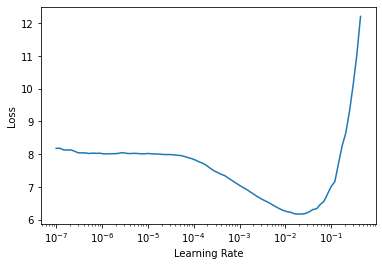

In [0]:
learn = Learner(dls, HFModelWrapper(electra_generator,hf_tokenizer.pad_token_id),  
                loss_func=LabelSmoothingCrossEntropyFlat(), 
                metrics=accuracy,
                opt_func=ranger,
                cbs=[mlm_cb]).to_fp16()

# help you find the best learning rate for "one cycle learning rate schedule"
# the graph below is the result of learning rate finding
lr, _ = learn.lr_find()

learn.fit_one_cycle(1, lr) 

# 3. ELECTRA (replaced token detection objective)

see details on arxiv [ELECTRA: Pre-training Text Encoders as Discriminators Rather Than Generators](https://arxiv.org/abs/2003.10555)

In [0]:
class Electra(nn.Module):
  def __init__(self, generator, discriminator):
    super().__init__()
    self.generator = generator
    self.discriminator = discriminator

In [0]:
class ElectraCallback(MaskedLMCallback):
  run_after=MixedPrecision
  @delegates(MaskedLMCallback.__init__)
  def __init__(self, electra_model, mask_tok_id, special_tok_ids, vocab_size, loss_weights=(1.0, 50.0), **kwargs):
    super().__init__(mask_tok_id, special_tok_ids, vocab_size, **kwargs)
    assert len(loss_weights)==2, 'loss_weights should contain element 0 and 1 for weight of generator loss and dicriminator loss respectively.'
    store_attr(self, 'electra_model, mask_tok_id, loss_weights')
    """
    This is equivalent of tf.nn.sigmoid_cross_entropy_with_logits, which is a sigmoid layer before cross entropy,
    when value of targes is either 1.0 or 0.0 .
    """
    self.discri_loss_func = nn.BCEWithLogitsLoss()
  
  def begin_fit(self):
    for cb in self.cbs:
      if isinstance(cb, MixedPrecision): self.fp16_cb = cb
  def after_fit(self):
    if hasattr(self, 'fp16_cb'): delattr(self, 'fp16_cb')

  def after_loss(self):
    # prepare discriminator's inputs and labels
    masked_inputs, labels = self.xb[0], self.yb[0] # both (batch size, sequence length)
    masked_pos_mask = masked_inputs == self.mask_tok_id # 1 for masked position, 0 for the others
    pred_toks = self.pred.argmax(dim=-1)
    generated = masked_inputs + masked_pos_mask * pred_toks # use predicted token to fill masked position
    replaced = (masked_pos_mask & (pred_toks != labels))  # is masked token and not equal to predicted
    
    discri_pred = self.electra_model.discriminator(generated).to(dtype=self.pred.dtype) # (bs, seq_len, 1)
    discri_pred = discri_pred.squeeze(-1) # (bs, seq_len)
    if hasattr(self, 'fp16_cb'): discri_pred = to_float(discri_pred)
    discri_loss = self.discri_loss_func(discri_pred, replaced.to(dtype=discri_pred.dtype))
    if hasattr(self, 'fp16_cb'): discri_loss *= self.fp16_cb.loss_scale
    self.learn.loss = torch.stack([self.loss, discri_loss]).matmul(torch.tensor(self.loss_weights, dtype=self.loss.dtype, device=self.loss.device))

    self.learn.model = self.electra_model

  def begin_batch(self):
    super().begin_batch() # -> self.xb, self.yb = (masked_inputs,),(answers,)
    self.learn.model = self.electra_model.generator

* The loss is very large

  Because Electra scales the discriminator loss by 50.

* Original optimization hyperparamter and schedule

  see [config](https://github.com/google-research/electra/blob/79111328070e491b287c307906701ebc61091eb2/configure_pretraining.py#L40) of the offcial repository



epoch,train_loss,valid_loss,accuracy,time
0,523.685852,12.675475,0.007071,01:36


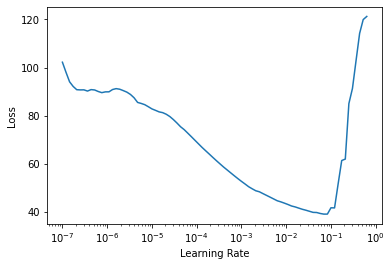

In [0]:
electra_model = Electra(HFModelWrapper(electra_generator, pad_id=hf_tokenizer.pad_token_id), 
                        HFModelWrapper(electra_discriminator, pad_id=hf_tokenizer.pad_token_id))

electra_cb = ElectraCallback(electra_model, 
                             mask_tok_id=hf_tokenizer.mask_token_id, 
                             special_tok_ids=hf_tokenizer.all_special_ids, 
                             vocab_size=hf_tokenizer.vocab_size)
learn = Learner(dls, electra_model,  
                loss_func=LabelSmoothingCrossEntropyFlat(), # will only be applied to generator, the loss function for discriminator is specified in callback 
                metrics=accuracy,
                opt_func=ranger,
                cbs=[electra_cb]).to_fp16()

# help you find the best learning rate for "one cycle learning rate schedule"
# # the graph below is the result of learning rate finding
lr, _ = learn.lr_find()

learn.fit_one_cycle(1, lr)